In [1]:
#imports used in this assignment
import numpy as np
import ad
import math
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from desdeo_problem.problem import MOProblem
from desdeo_problem.problem.Variable import variable_builder
from desdeo_problem.problem.Objective import _ScalarObjective
from desdeo_mcdm.utilities import payoff_table_method as ptm
from desdeo_problem.surrogatemodels import GaussianProcessRegressor
from desdeo_problem import VectorDataObjective as VDO
from desdeo_problem import DataProblem
from desdeo_problem import ScalarDataProblem
from desdeo_mcdm.utilities import payoff_table_method

<h2> Assignment </h2>

<h3> About this assignment </h3>
<p> This is the final assignment for Nonlinear optimization course </p> 

<h3> Problem 1 </h3>
<p> In this problem we will be forming, solving and analysing a optimization problem as follows: </p> 
<p> A window is being built and the bottom is a rectangle and the top is a semicircle. If there is 12 m of framing materials what must the dimensions of the window be to make the window area as big as possible? </p> 

<p> We can model the problem as follows: </p>

<li> Area of circle is $\pi r^2$ and we only need half of this circle for our window so we get that $\frac{\pi r^2}{2} $ and simplifying to $\pi r$</li>

<li> For rectangle we will need the height and width $h \times w$. We know that the width of the rectangle is equal to $w = r^2$ so we need to figure out the height $h$  </li>

<li> Constraint for this problem is that we can only use $≤12m$ of framing materials. So we can define our constraint as $2h + r^2 + \pi r ≤ 12$ </li>

<p> Now we can write this as an optimization problem: </p>

$$
\begin{equation}
\begin{aligned}
\begin{cases}
 \max & f(h,r) = \pi r + hr^2 \\
\text{s.t.}   & 2h + r^2 + \pi r ≤ 12 \\
\end{cases}
\end{aligned}
\end{equation}
$$

<p> This is a two variable objective optimization problem with inequality constraint. </p> 
<p> We can use simple penalty method to solve this problem </p>

In [5]:
#Define function and constraint
#here x_0 = r and x_1 = h
#We multiply the function by -1 because we will be using minimization to solve the problem
def f(x):
    return -1 * (math.pi * x[0] + x[1] * x[0]**2), [] ,[-1*(2*x[1] + x[0]**2 + math.pi * x[0] - 12)]

In [6]:
#Define alpha as:
def alpha(x,f):
    (_,ieq,eq) = f(x)
    return sum([min([0,ieq_j])**2 for ieq_j in ieq]) + sum([eq_k**2 for eq_k in eq])

#Penalized function:
def penalized(x,f,r):
    return f(x)[0] + r*alpha(x,f)

In [7]:
r = 1 # We will start with r = 1
#precision can be changed depending how accurate answer we want
precision = 0.00000001
a = np.array([float('inf')])
#starting point at 0 to 12
b = [0,12]
steplist_penalty = []
iter0 = 0
while iter0 < 200:
    a = b
    res = minimize(lambda x:penalized(x,f,r), a, method='Nelder-Mead', options={'disp': False})
    b = np.array(res.x)
    r = r + 50
    iter0 = iter0 + 1
    steplist_penalty.append(list(b))
print("res: ", res)
print("Solution: ", "r: ", b[0], ", h: ", b[1])
print("iter: ", iter0)

res:   final_simplex: (array([[1.70453268, 1.86984732],
       [1.70454897, 1.86979344],
       [1.70450419, 1.86993971]]), array([-10.78760698, -10.78760697, -10.78760696]))
           fun: -10.787606976405089
       message: 'Optimization terminated successfully.'
          nfev: 62
           nit: 32
        status: 0
       success: True
             x: array([1.70453268, 1.86984732])
Solution:  r:  1.7045326824485132 , h:  1.8698473162702516
iter:  200


<p> We get that the radius $r = 1.7045326824485132$ and height of the rectangle $h = 1.8698473162702516$ with precicion of $0.00000001$ </p>
<p> We can chek if these satisfy our constraints: </p>

<p> Let $r = 1.7045326824485132$ and $h = 1.8698473162702516$ we get that: </p> 
<p> </p>
$$ 2(1.8698473162702516) + (1.7045326824485132)^2 + \pi (1.7045326824485132) ≤ 12 $$

In [8]:
res1 = 2*(1.8698473162702516)+(1.7045326824485132)**2 + math.pi* (1.7045326824485132)
print(res1)

12.00007365105958


<p> We get that the answer is ~$12$ with our precision so it satisfies our constraint. Now we can calculate the area of our window as: </p> 

$$ \pi (1.7045326824485132) + (1.8698473162702516) \times (1.7045326824485132)^2 $$

In [9]:
res2 = math.pi * (1.7045326824485132) + (1.8698473162702516) * (1.7045326824485132)**2
print(res2)

10.787660955391411


<h3> Analyzing </h3>
<p> We get that the size of our window (with precision of $0.00000001$) would be $10.787660955391411$ </p>
<p> We used penalty method to solve our optimization problem and got a pretty accurate answer. In our case we will need to round our answer a little bit so that it would satisfy the constraint for this problem. Other than that our answer is really accurate and penalty method works great for this kind of optimization problem. </p>

<h3> Problem 2 </h3>
<p> The $10$-dimensional Robsenbrock function (one of the variants) is defined as: </p> 

$$
\begin{equation}
\begin{aligned}
&f(x) = \sum_{i=1}^9 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2
&\textit{, where } x \in R^{10}
\end{aligned}
\end{equation}
$$

<p> We will be comparing at least two different optimization method's performance in minimizing this function over $R^{10}$. We can define our problem as a minimization optimization problem as: </p> 

$$
\begin{equation}
\begin{aligned}
\begin{cases}
\min &f(x) = \sum_{i=1}^9 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2 \\
\textit{s.t. } & x \in R^{10}
\end{cases}
\end{aligned}
\end{equation}
$$


<p> We will be using two different methods to solve this probelm: </p>
<li> 1. Penalized function method  </li>
<li> 2. Using Golden section and Steepest descen algorithmn </li>

<h3> Using penalty method method  </h3>

In [10]:
# Define function
def f(x):
    return (np.sum(100*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2), [], [])

# Define alpha as (from lectures):
def alpha(x,f):
    (_,ieq,eq) = f(x)
    return sum([min([0,ieq_j])**2 for ieq_j in ieq]) + sum([eq_k**2 for eq_k in eq])

# Penalized function (from lectures):
def penalized(x,f,r):
    return f(x)[0] + r*alpha(x,f)

r = 1 # We will start with r = 1
precision = 0.0001
a = np.array([float('inf')])
# Starting point at [-10,10, -10, 10, 1, -1, 0, 0, 10 ,10]
b = [-10,10, -10, 10, 1, -1, 0, 0, 10 ,10]
steplist_penalty = []
iter0 = 0
while iter0 < 500:
    a = b
    res = minimize(lambda x:penalized(x,f,r), a, method='Nelder-Mead', options={'disp': False})
    b = np.array(res.x)
    r = r + 10
    iter0 = iter0 + 1
    steplist_penalty.append(list(b))
print("res: ", res)

res:   final_simplex: (array([[1.00000118, 1.00000013, 1.00000001, 0.99999983, 0.99999817,
        0.99999721, 0.9999976 , 0.99999568, 0.99999063, 0.99998543],
       [1.00000104, 1.00000111, 1.00000092, 1.00000045, 1.00000158,
        1.00000541, 1.00000759, 1.00001342, 1.00002823, 1.0000541 ],
       [1.00000187, 1.00000063, 0.9999994 , 0.99999804, 0.99999685,
        0.99999766, 0.99999371, 0.99998803, 0.9999792 , 0.99995621],
       [1.00000316, 1.00000207, 1.00000185, 1.00000258, 1.00000241,
        1.00000502, 1.00000811, 1.00001794, 1.0000371 , 1.00007395],
       [1.00000329, 1.0000045 , 1.00000225, 1.00000255, 1.00000143,
        1.00000136, 1.00000186, 1.00000265, 1.00000735, 1.00001361],
       [1.00000089, 0.99999964, 0.99999885, 0.99999833, 1.00000202,
        1.00000586, 1.00000643, 1.00001431, 1.00002806, 1.0000562 ],
       [1.00000204, 0.9999994 , 0.99999925, 1.00000074, 0.99999932,
        0.99999843, 0.99999556, 0.99998855, 0.99997271, 0.99994117],
       [1.00000355

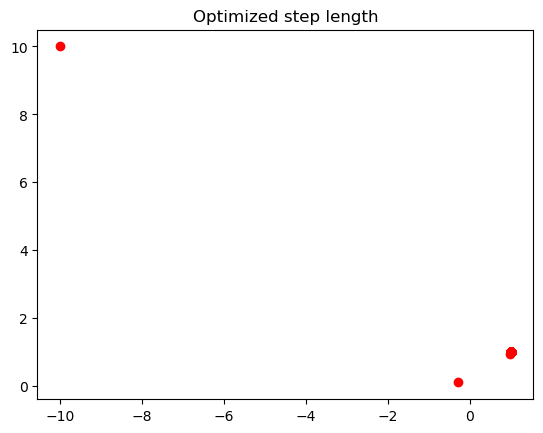

In [12]:
start = [-10,10, -10, 10, 1, -1, 0, 0, 10 ,10]
vector = np.array([start] + steplist_penalty).transpose()
plt.title("Optimized step length")
plt.plot(vector[0,], vector[1,], 'ro')

<H3> Using Golden section and Steepest descen algorithmn </H3>

In [13]:
#Define function
def f(x):
    return np.sum(100*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

#Using golden section and steepest-descent to solve our problem:
def golden(a,b,f,L):
    #(Set x as the start point of interval and y as the end point)
    x = a
    y = b
    #(Divide the interval [x,y] in the golden section from the left and right and attain two division points
    #If the greater of the division points has a greater function value 
    #set y as the rightmost division point, because a local optimum is before that)
    while y-x>2*L:  
        left_ratio = y-((math.sqrt(5.0)-1)/2.0)*(y-x)
        right_ratio = x+((math.sqrt(5.0)-1)/2.0)*(y-x)   
        if f(left_ratio) < f(right_ratio):
            y = right_ratio
        #(otherwise:
        #set x as the leftmost division point, because a local optimum is after that)
        else:
            x = left_ratio
    #return midpoint between x and y
    return (x+y)/2


def steepest_descent_golden(f,start,length,precision):
    x = np.array(start)
    func_old = float('Inf')
    d = float('Inf')
    func_new = f(x)
    steplist = []
    while abs(func_old - func_new) > precision:
            func_old = func_new
            # Calculate gradient using finite difference method
            epsilon = 1e-4
            gradient = np.zeros_like(x)
            for i in range(x.shape[0]):
                x_plus = x.copy()
                x_plus[i] += epsilon
                x_minus = x.copy()
                x_minus[i] -= epsilon
                gradient[i] = (f(x_plus) - f(x_minus)) / (2 * epsilon)
            d = -gradient / np.linalg.norm(gradient)
            # Implementing golden section for optimization of step length
            # Golden section algorithm is the same one used at Exercise 2
            step = golden(0, length, lambda i: f(x + i * d), precision)  
            x = x + d * step # Take a step
            func_new = f(x) # New value
            steplist.append(list(x))
    return x, steplist


In [14]:
start = [-10,10, -10, 10, 1, -1, 0, 0, 10 ,10]
precision = 0.0001
(x,steplist) = steepest_descent_golden(f, start, 3, precision)
print ("Min: ", x)

Min:  [-0.9946032   0.99926233  1.00353545  1.00959882  1.02056457  1.04229738
  1.08683835  1.18196436  1.3976634   1.95536965]


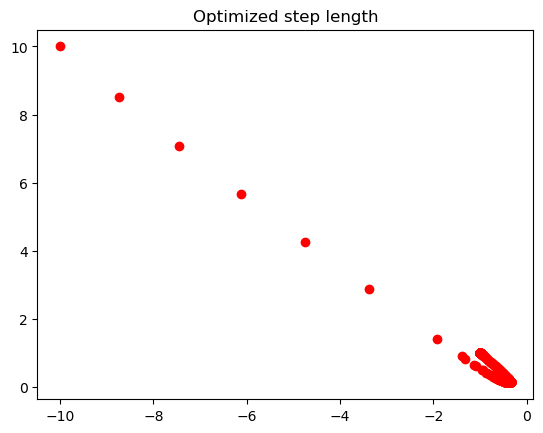

In [15]:
vector = np.array([start] + steplist).transpose()
plt.title("Optimized step length")
plt.plot(vector[0,], vector[1,], 'ro')

<h4> Analyzing </h4>
<p> With penalty method we get that Min: [1.00000118, 1.00000013, 1.00000001, 0.99999983, 0.99999817,
       0.99999721, 0.9999976 , 0.99999568, 0.99999063, 0.99998543] </p>
       
<p> And with steepest descend we get that Min:  [-0.9946032   0.99926233  1.00353545  1.00959882  1.02056457  1.04229738
  1.08683835  1.18196436  1.3976634   1.95536965]</p>
<p> Answers we get differ a little bit but are still pretty close to each other. What we can see from our graphs is that the penalty method get's closer to minima with fever steps that steepest descent. But steepest descent seems to be more accurate in this case and for example the graph is way easier to read. </p>

<p> We can also see that minimization seems to happen from different directions as penalty method gets answers so that $x < 1$ while the steepest descent seems to be getting answers so that $x > 1$  </p>

<h3> Problem 3 </h3>
<p> In this problem we will be studying a bi-objective optimization problem that is defined as follows: </p> 

$$
\begin{equation}
\begin{aligned}
\begin{cases}
 \max & \{ \| (x-(1,0)) \| \textit{ , } \| (x - (0,1)) \| \} \\
\text{s.t.}  & x \in R^2 \\
\end{cases}
\end{aligned}
\end{equation}
$$

We can rewrite this problem as:

$$
\begin{equation}
\begin{aligned}
\begin{cases}
 \max \qquad & f_1(x) = \| (x-(1,0)) \|  \\
 \max \qquad & f_2(x) = \| (x-(0,1)) \| \\
 \text{s.t.} \qquad  & x \in R^2 \\
 \end{cases}
\end{aligned}
\end{equation}
$$

<p> From here we will get that: </p>

$$
\begin{equation}
\begin{aligned}
\begin{cases}
 \max \qquad & f_1(x) = \| x_1 - 1 + x_2  \|  \\
 \max \qquad & f_2(x) = \| x_1  + x_2 - 1 \| \\
 \text{s.t.} \qquad  & x \in R^2 \\
 \end{cases}
\end{aligned}
\end{equation}
$$

In [8]:
#let's start by defining our functions
#We need to multiply by -1 because we are minimizing our functions
def f(x):
    return [-1*((x[0] - 1) + x[1]),-1*(x[0] + (x[1]-1))]

w = np.random.random ((500,2)) #Random weights

In [3]:
#From the lectures we get the function for weighing method as:
def weighting_method(f,w):
    start = [0,0] #starting values for the variables 
    points = []
    for wi in w:
        res=minimize(
            #weighted sum
            lambda x: sum(np.array(wi)*np.array(f(x))), 
            start, method='SLSQP',
            #Jacobian using automatic differentiation
            jac=ad.gh(lambda x: sum(np.array(wi)*np.array(f(x))))[0])
        points.append(res.x)
    return points

In [4]:
res = weighting_method(f,w)
print("head: ", res[:10])
print()
print("tail: ", res[-10:])

head:  [array([2.70162084e+15, 2.70162084e+15]), array([3.94635253e+15, 3.94635253e+15]), array([4.08001734e+15, 4.08001734e+15]), array([3.30584077e+15, 3.30584077e+15]), array([2.2178044e+15, 2.2178044e+15]), array([3.60152039e+15, 3.60152039e+15]), array([3.77551805e+15, 3.77551805e+15]), array([2.18084521e+15, 2.18084521e+15]), array([1.89620484e+15, 1.89620484e+15]), array([4.94349358e+15, 4.94349358e+15])]

tail:  [array([3.03164308e+15, 3.03164308e+15]), array([2.50165689e+15, 2.50165689e+15]), array([2.43806785e+15, 2.43806785e+15]), array([2.66607742e+15, 2.66607742e+15]), array([3.27382756e+15, 3.27382756e+15]), array([2.69625282e+15, 2.69625282e+15]), array([2.16798135e+15, 2.16798135e+15]), array([1.63914908e+15, 1.63914908e+15]), array([2.87031111e+15, 2.87031111e+15]), array([2.18330539e+15, 2.18330539e+15])]


In [5]:
f_values = np.array([f(x) for x in res])
print("head: ", f_values[:10])
print()
print("tail: ", f_values[-10:])

head:  [[-5.40324167e+15 -5.40324167e+15]
 [-7.89270507e+15 -7.89270507e+15]
 [-8.16003468e+15 -8.16003468e+15]
 [-6.61168154e+15 -6.61168154e+15]
 [-4.43560881e+15 -4.43560881e+15]
 [-7.20304078e+15 -7.20304078e+15]
 [-7.55103610e+15 -7.55103610e+15]
 [-4.36169042e+15 -4.36169042e+15]
 [-3.79240968e+15 -3.79240968e+15]
 [-9.88698715e+15 -9.88698715e+15]]

tail:  [[-6.06328617e+15 -6.06328617e+15]
 [-5.00331378e+15 -5.00331378e+15]
 [-4.87613571e+15 -4.87613571e+15]
 [-5.33215484e+15 -5.33215484e+15]
 [-6.54765512e+15 -6.54765512e+15]
 [-5.39250563e+15 -5.39250563e+15]
 [-4.33596270e+15 -4.33596270e+15]
 [-3.27829816e+15 -3.27829816e+15]
 [-5.74062222e+15 -5.74062222e+15]
 [-4.36661078e+15 -4.36661078e+15]]


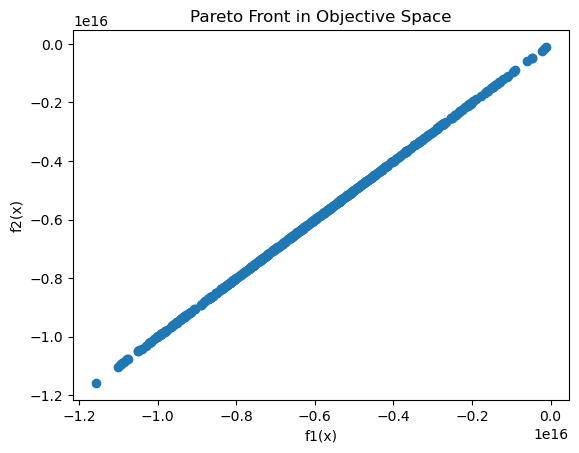

In [6]:
# Plot Pareto front in objective space
plt.scatter(f_values[:, 0], f_values[:, 1])
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.title('Pareto Front in Objective Space')
#plt.xlim(-2,1)
#plt.ylim(-2,1)
plt.show()

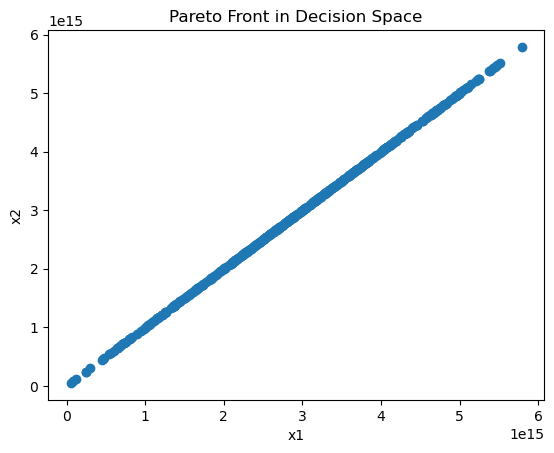

In [7]:
#Plot pareto front in decision space
plt.scatter([x[0] for x in res], [x[1] for x in res])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Pareto Front in Decision Space')
plt.show()

<h3> Analyzing </h3>
<p> From what we can see is that Pareto Front in both Decision- and Objective space is a eavenly spread straight line as it should be. From this we can interpret that the weighing method works as it should. We can also interpret that from this straight line it would be pretty hard to make good decisions. In this case we should also find out nadir and ideal vectors to help with decision making. Or use some kind of constraints to help with it. </p> 

<h3> Problem 4 </h3>
<p> For this problem we read a research paper "A mixed-integer stochastic nonlinear optimization problem with joint probabilistic constraints" by Thomas Arnold, René Henrior, Andris Möller, Stefan Vigerske </p> 
<li> https://oa.tib.eu/renate/bitstream/123456789/1690/1/750690720.pdf </li> 
<p> In this paper we have a stochastic nonlinear optimization problem that focuses on power management. In this paper a hydro power station and a wind farm is considered and generation of wind energy is assumed to be random. </p>
<p> And from that we get the optimization problem as: </p>

$$
\begin{equation}
\begin{aligned}
\begin{cases}
 \max &  \sum_{t = 1}^T \pi_t y_t\\
\text{s.t.}   & P (x_t + \xi_t ≥ d_t \textit{ } \forall t = 1,...,T) \\
\end{cases}
\end{aligned}
\end{equation}
$$

<p> Here we need to keep in mind that there should be more constraints, but I wanted to focus on the one with probability in this case. </p>

In [89]:
#We will start by defying our variables and creating our dummy data for this problem
#Our time is 2 full days, so 40 hours

T = 40  # number of time periods
mu = 100  # mean of the price and demand
sigma = 20  # standard deviation of the price and demand

pi = np.random.normal(mu, sigma, size=T).reshape(-1,1)
d = np.random.normal(mu, sigma, size=T).reshape(-1,1)

#Our objective function
f = (pi[:,0] * d[:,0]).reshape(-1,1)

raw_data = np.hstack((pi, d, f))

X = ["price", "demand"]
y = ["func"]

#We can check how our data looks using pandas
data = pd.DataFrame(raw_data, columns=X+y)
data.head()

,price,demand,func
0,140.665968,126.522613,17797.425828
1,87.378186,89.243222,7797.910861
2,105.328713,140.460622,14794.536475
3,75.159999,120.111303,9027.565410
4,100.651811,125.165768,12598.161228


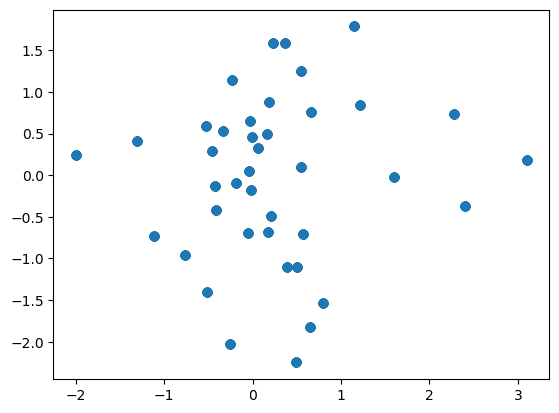

In [50]:
#define the mean vector and covariance matrix
mean = np.zeros(T)
cov = np.eye(T)

#generate random data from the multivariate normal distribution
xi = np.random.multivariate_normal(mean, cov, size=T)
plt.scatter([xi[0] for x in xi], [xi[1] for x in xi])

In [123]:
#We will use DESDEO to solve this probelm
# Define the objective function

#def objective_function(x):
#    return sum([pi[t]*x[t] for t in range(T)])

# Define the constraint function
def constraint_function(x):
    return all([np.dot(x, xi[t]) >= d[t] for t in range(T)])

# Define the decision variables
nvars = T
variable_bounds = [(0, 1)] * nvars

const1 = _ScalarObjective(name="const1", evaluator=constraint_function)
constraint = [const1]

#des = data.loc[:, ['price', 'demand']]
#fs = data["func"]
#print(des.head(), fs.head())


In [161]:
# Define the optimization problem as DataProblem
#help(DataProblem)
problem = DataProblem(data = data, objective_names = y, variable_names = X, constraints = constraint)
problem

In [199]:
# We can then solve this with different optimization methods like Gaussian Process Regressor
problem.train(GaussianProcessRegressor)
#help(problem.evaluate)

#problem.evaluate(decision_vectors , use_surrogate=True)
#print(problem.ideal, problem.nadir)

<h4> Analyzing the results </h4>
<p> We made our problem into a DataProbelm using DESDEO framework. This problem can then be solved using different optimization methods like Gaussian Process Regressor. </p>